# Introduction
In addition to the ALS model for the Recommender System it has been decided to conduct an exeperiment trying to create a Recommender System based not on the opinions (reviews and ratings) that other users left for the items but trying to find a way to cluster games in the attempt to find the most similar games basing the similarity over their plots.

In order to try to do that, in the following section of this notebook the process to obtain the clustering of the items starting from their plot is presented: it has been decided to try to cluster them thanks to a K-Means clustering algorithm.

In the following section it will be described in detail how it was possible to pre-process the raw data in order to make it usable for the clustering model thanks to a common pipeline used in NLP to process texts

# Needed library import and framework setting
In this section the needed library for the code will be imported and the Java framework for the clustering will be created

In [ ]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=1be3368d549688a023c68e0ebefc74160833b01b86ad86c530b0060576c21f92
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:
!ngrok authtoken 2Tn9uykXlYRjLcSLIgmv1iLdEvG_3gqA9M3V4hLGqH9N3JWEr

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from pyngrok import ngrok
import os
import re

# Framework Setting
In this section the framework needed in order to work with the clustering algorithm is set

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"

RANDOM_SEED = 42 # for reproducibility

In [ ]:
!apt install openjdk-8-jdk-headless -qq

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u382-ga-1~22.04.1_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u382-ga-1~22.04.1) ...

In [ ]:
os.environ["JAVA_HOME"] = JAVA_HOME

# PySpark Initialization
In this section the PySpark session will be initalizated

In [ ]:
# Install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=905c4f687c582d4ee49a107f096e72a23d7a897aca3642b03f352b7516dc0941
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Import libraries
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as sqlf
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.ml.feature import HashingTF, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Normalizer
from pyspark.ml.evaluation import ClusteringEvaluator
import gc

In [ ]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("VideogameClustering").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
port = '4050'
public_url = ngrok.connect(port).public_url

In [ ]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://856d-34-74-132-107.ngrok.io" -> "http://127.0.0.1:4050"


In [ ]:
spark

# Connection to Google Drive

In [ ]:
# Connect this colab to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Utils

In [ ]:
def clean_links(raw_text):
  '''
  The function removes all the links from a text thanks to the regex called
  CLEANER_LINKS
  '''
  CLEANER_LINKS = re.compile('http[s]?://\S+')
  cleantext = re.sub(CLEANER_LINKS, '', raw_text)
  return cleantext

In [ ]:
def clean_punctuation(raw_text):
  '''
  The function removes all the punctuation from a text thanks to the regex called
  CLEANER_PUNCTUATION
  '''
  CLEANER_PUNCTUATION = re.compile('[^\w\s]')
  cleantext = re.sub(CLEANER_PUNCTUATION, ' ', raw_text)
  return cleantext

In [ ]:
def clean_extra_spaces(raw_text):
  '''
  The function removes all the extra whitespaces (meaning that if it finds
  consecutive whitespaces it will reduce it to one) from a text thanks to the
  regex called CLEANER_PUNCTUATION
  '''
  CLEANER_EXTRA_SPACES = re.compile('\s\s+')
  cleantext = re.sub(CLEANER_EXTRA_SPACES, ' ', raw_text)
  return cleantext

The UDFs for all the cleaner functions are now created in order to make them applicable to the dataframe columns

In [ ]:
clean_links_UDF = sqlf.udf(lambda x : clean_links(x), StringType())

In [ ]:
clean_punctuation_UDF = sqlf.udf(lambda x : clean_punctuation(x), StringType())

In [ ]:
clean_extra_spaces_UDF = sqlf.udf(lambda x : clean_extra_spaces(x), StringType())

In [ ]:
@sqlf.udf("long")
def num_nonzeros(v):
  '''
  This function is used to evaluate if the value for the column in a row of the
  dataset contains values that are not zeros
  '''
  return v.numNonzeros()

The following function, called **process_data_for_clustering** implements a simple and common pipeline used to pre-process a text in order to make it usable later on for clustering activities.

Specifically the function perform the following actions:


1.   Remove all the unuseful informations like **links** and **initial and finals whitespaces** thanks to the *clean_links* and *trim* functions applied to the specific column of the dataset that contains the textual information that need the pre-processing
2.   In order to overcome the resources limitation of the RAM available for the computation it has been necessary perform the clustering only on a sample of the data; in the attempt to get the most useful sample of the data it has been decided to remove all the games for which it has not been registered a new review on the Steam platform in the past 365 days. The sample has been reduced from more or less 131000 games to more or less 15000 (and also with this little amount of samples the RAM was pretty much all filled during the computation)
3.   The typical pipeline for the NLP processing is then performed: specifically the text is **all transformed to lowercase**, **deprivied of punctuation**, **deprivied of extra whitespaces created during the removal of the punctuation**; in order to maintain only the useful information the **tokeinzation** and the **removal of the stop words** is then performed (using the remover of the stop words provided by the PySpark ML library); finally the remained words are **reduced to thier stem** in order to better compute the similarities of the texts. This last part of the pipeline has been made thanks to the Stemmer provided by the Python Natural Language Toolkit (NLTK)
4.   Thanks to the Count Vectorizer, the **frequency of a term in the text** (TF) is computed
5.   Finally the IDF (Inverse Document Frequency) is computed
6.   So the final TF-IDF dataset is computed and from it all the entries for which the number of features is zero are deleted

In [ ]:
def process_data_for_clustering(dataset_df,
                                column_name):
  '''
  This function is used to pre-process the textual data present in the column
  column_name of the dataframe dataset_df in order to prepare it for the
  clustering
  '''
  # Remove NaNs values and unuseful information
  dataset_df = dataset_df.dropna()
  dataset_df = dataset_df.withColumn(column_name, clean_links_UDF(sqlf.col(column_name)))
  dataset_df = dataset_df.withColumn(column_name, sqlf.trim(sqlf.col(column_name)))

  # Restrict the dataset to a more little sample and get only the most useful
  # and recently played games
  dataset_df = dataset_df.where(dataset_df.total_recommendations > 0)

  #                     *** NLP PRE-PROCESS PIPELINE ***
  # Transform the text to lower case
  dataset_df = dataset_df.withColumn(column_name, sqlf.lower(sqlf.col(column_name)))
  # Remove punctuation
  dataset_df = dataset_df.withColumn(column_name, clean_punctuation_UDF(sqlf.col(column_name)))
  # Remove extra spaces
  dataset_df = dataset_df.withColumn(column_name, clean_extra_spaces_UDF(sqlf.col(column_name)))

  # Tokenize the text
  tokenizer = Tokenizer(inputCol=column_name, outputCol='tokens')
  tokens_df = tokenizer.transform(dataset_df)

  # Remove the stopwords
  stopwords_remover = StopWordsRemover(inputCol='tokens', outputCol='terms')
  terms_df = stopwords_remover.transform(tokens_df)

  # Reduce the words to thier stem
  stemmer = SnowballStemmer(language="english")
  stemmer_udf = sqlf.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
  terms_stemmed_df = terms_df.withColumn('terms_stemmed', stemmer_udf('terms'))

  # Compute the term frequency in the text
  cv = CountVectorizer(inputCol='terms_stemmed', outputCol="tf_features", vocabSize=1000, minDF=10)
  # Compute the inverse term frequency of the term in the text
  idf = IDF(inputCol="tf_features", outputCol="features")

  pipeline = Pipeline(stages=[cv, idf])
  # Compute the features that represent the text
  features = pipeline.fit(terms_stemmed_df)
  tf_idf_df = features.transform(terms_stemmed_df)

  # Remove the entries for which the features computed are 0
  tf_idf_df = tf_idf_df.where(num_nonzeros("features") > 0)

  return tf_idf_df

The following funciton is used to fit a K-Means model used to create cluster of the texts, since the **cosine similarity** is used as distance method it is needed to normalize the features so to make possible the computation of the cosine similarity.

It is important to notice that the values given to the parameters are the one that made possible the fitting of the best models by staying also under the RAM limitations

In [ ]:
def k_means(dataset,
            n_clusters,
            features_col='features',
            prediction_col='cluster',
            random_seed=RANDOM_SEED):
  '''
  This function is used to normalize the features computed during the pre-procesing
  and then use the normalized features to fit the K-Means model.
  The function, together with the fitted model, returns a dataframe containing the
  mapping of each entry to the corresponding cluster
  '''
  dataset = Normalizer(inputCol=features_col, outputCol=features_col+"_norm", p=1).transform(dataset)
  features_col = features_col+"_norm"

  k_means = KMeans(
      featuresCol=features_col,
      predictionCol=prediction_col,
      k=n_clusters,
      initMode='k-means||',
      initSteps=5,
      tol=0.000001,
      maxIter=20,
      seed=random_seed,
      distanceMeasure='cosine'
      )
  model = k_means.fit(dataset)

  clusters_df = model.transform(dataset)

  return model, clusters_df

In [ ]:
def evaluate_k_means(clusters,
                     metric_name="silhouette",
                     distance_measure="cosine",
                     prediction_col="cluster"
                     ):
  '''
  This function is used to evaluate the performace of the cluster with the
  silhouette metrics which is able to capture how much different clusetrs are
  different from each other
  '''
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure,
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

# Data Retrieving and Pre-Process
In this section the data needed for clustering are retrieved and then preprocessed to get the tf-idf dataset

In [ ]:
games_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [ ]:
tf_idf_df = process_data_for_clustering(games_df, 'about_the_game') # or short_description

# Clustering
In this section the fit of the models is computed.

It is important to know that the fit of the clustering has been tried over different values of K and over different columns. Specifically the columns and the value fo K tested are the following:

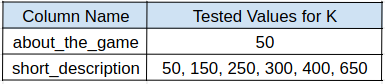

It is also important to notice that it has only been possible to perform a single configuration for the clustering of the *about_the_game* texts due to the RAM limitations.

The final models (for which a detailed analysis is provided in the notebook called *Clustering_Analysis*) chosen are:


*   **about_the_game**: K=50
*   **short_description**: K=300





In [ ]:
k = 100
print("Running K-means using K = {:d}".format(k))
model, clusters_df = k_means(tf_idf_df, k)
silhouette_k = evaluate_k_means(clusters_df)
wssd_k = model.summary.trainingCost
print("Silhouette coefficient computed with cosine distance: {:.3f}".format(silhouette_k))
print("Within-cluster Sum of Squared Distances (using cosine distance): {:.3f}".format(wssd_k))

In [ ]:
path = '/content/gdrive/MyDrive/VideogameRecommenderSystem/models/KMEANS_about_K_{}'.format(k) # or KMEANS_short_K_{}
model.save(path)